In [787]:
import numpy as np
import sklearn.model_selection as ms
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor

# Контест на Kaggle.com

https://inclass.kaggle.com/c/demand-prediction

Спрогнозируйте количество проданных товаров, используя исторические данные о продажах

### Задача

В этом соревновании вам предстоит решить задачу прогнозирования спроса. Результатом работы вашей модели должны быть ровно 2016 прогнозов продаж товаров за три недели в 2015 году.

### Данные

Предоставленные выборки уже содержат предподсчитанные средние значения продаж по разным срезам (за различные периоды времени), которые можно использовать как признаки.

При этом никто не ограничивает вас в дополнительной работе с признаками при решении контеста. Например, item_id - идентификатор товара, для которого решается задача прогнозирования спроса - категориальный признак с большим количеством принимаемых значений, и может быть хорошей идеей не использовать его как число, а закодировать каким-то еще образом, отличным от уже полученного в признаках. Но будьте осторожны с переобучением!

Чтобы защититься от переобучения, вам будет полезно смотреть на качество на кросс-валидации. Однако в ваших данных есть зависимость от времени. Подумайте, как это должно сказаться на кросс-валидации.

Также вам стоит иметь ввиду, что у тестовой выборки есть публичная и приватная части - до окончания соревнования вы видите только результат на публичной части, после окончания - результат с учетом приватной части.

### Дополнительные файлы

Вам предоставлен файл sample_submission.tsv с константным ответом на тестовой выборке и код бейзлайна, использующего градиентный бустинг над деревьями из sklearn. Хорошие идеи по улучшению качества:

поменять параметры в предоставленном бейзлайне
попробовать как-то преобразовывать ответы на обучающей выборке, обучать на преобразованные ответы модель, а потом выполнять обратное преобразование (ведь используемый метод может минимизировать MSE, а ваше решение оценивается по SMAPE)
попробовать применить другие алгоритмы

In [913]:
import pandas as pd
from copy import deepcopy

train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

In [914]:
secret_test = pd.read_csv("train.tsv")[60000:]
train = train[:60000]

In [915]:
original_train = pd.read_csv('train.tsv')
original_test = pd.read_csv('test.tsv')

В датасете фичи не соответствуют данным. Уберем это преобразованием:

In [892]:
def transform(data):
    for i, row in data.iterrows():
        shift = row['shift']
        if 1 <= row['week'] - shift <= 52:
            data.set_value(i, 'week', row['week'] - shift)
        else:
            if (row['year'] == 2015):
                data.set_value(i, 'week', 52 + (row['week'] - shift))
            else:
                data.set_value(i, 'week', 52 + (row['week'] - shift))
            data.set_value(i, 'year', row['year'] - 1)

In [794]:
transform(train)
train.drop(['shift', 'Num', 'y'], axis=1, inplace=True)
train = train.drop_duplicates()
merged_table = pd.merge(train, Y_table, how='right', on=['year', 'week', 'item_id'])
merged_table = merged_table.drop_duplicates()
merged_table = merged_table.dropna()

In [795]:
transform(test)
test.drop('Num', axis=1, inplace=True)
test.drop('shift', axis=1, inplace=True)

In [796]:
print len(test)
test.drop_duplicates()
print len(test)

2016
2016


## Baseline solution (Gradient Boosting на 10% выборки)

In [797]:
frac = 0.1

merged_slice = merged_table.sample(frac=frac, random_state=42)

X = merged_slice.drop(['y'], axis=1)
y = merged_slice['y']
print len(X), len(y)

1993 1993


In [798]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=43)
model.fit(X, y)


preds = model.predict(test)

print len(preds)
print len(sample_submission)

2016
2016
CPU times: user 2 s, sys: 24 ms, total: 2.02 s
Wall time: 2.05 s


In [799]:
preds

array([  3.19451210e+03,   4.07221291e+04,   6.36013927e+05, ...,
         2.47576363e+04,   3.57660777e+02,   6.86091218e+03])

In [800]:
def smape100(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)) / ((np.abs(y_true) + np.abs(y_pred))*0.5)) * 100

smape_scorer100 = make_scorer(smape100, greater_is_better=False)

In [801]:
result = ms.cross_val_score(model, X, y, scoring=smape_scorer100)
print result.mean()

-9.60474827373


In [802]:
def get_train_and_target(apply_func=lambda x: x):
    table = deepcopy(merged_table)
    apply_func(table)
    X = table.drop(['y'], axis=1)
    Y = table['y']
    return X, Y

In [811]:
smape_scorer100(model, X_test_control, Y_test_control)

-7.0927112801310965

Соединим таблицу для обучения так, чтобы фичи и y соответствовали одной и той же дате и предмету:

In [916]:
test = deepcopy(original_test)
train = deepcopy(original_train)
correct_Y = deepcopy(train[['y', 'year', 'week', 'item_id']])
transform(test)
transform(train)
test.drop(['shift', 'Num'], axis=1, inplace=True)
train.drop(['shift', 'Num', 'y'], axis=1, inplace=True)
train = train.drop_duplicates()

merged_table = pd.merge(train, correct_Y, how='right', on=['year', 'week', 'item_id'])
merged_table = merged_table.drop_duplicates()
merged_table = merged_table.dropna()

Нарисуем графики от фичей:

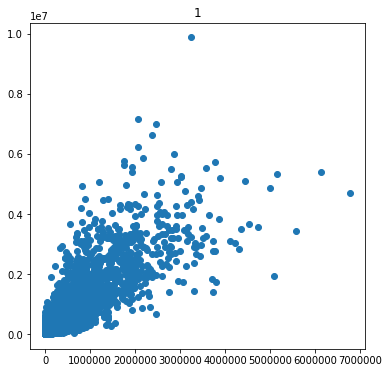

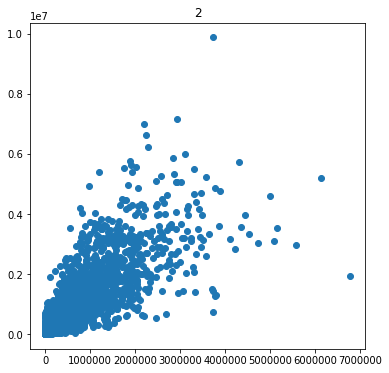

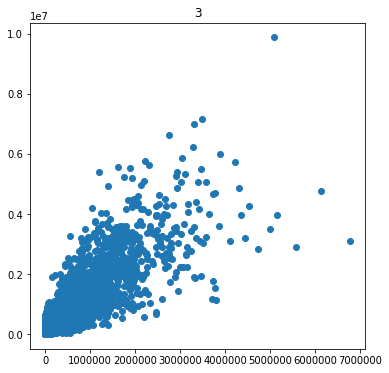

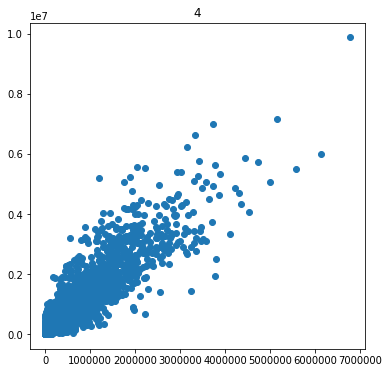

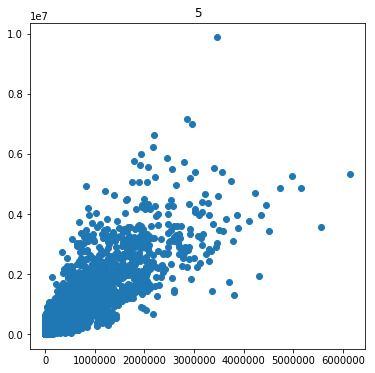

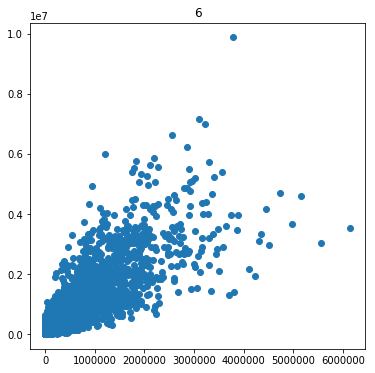

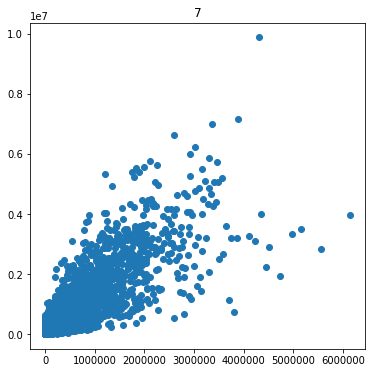

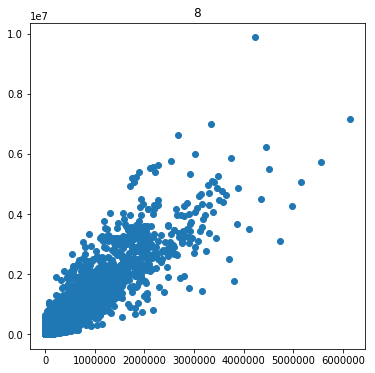

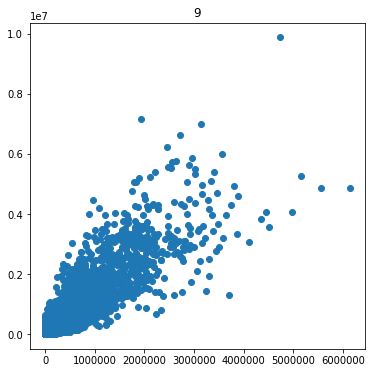

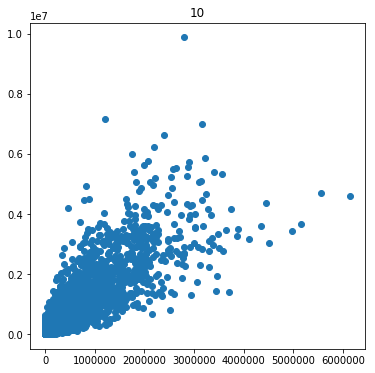

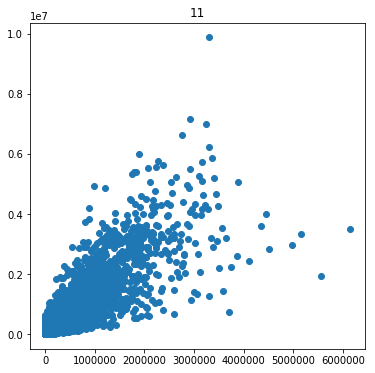

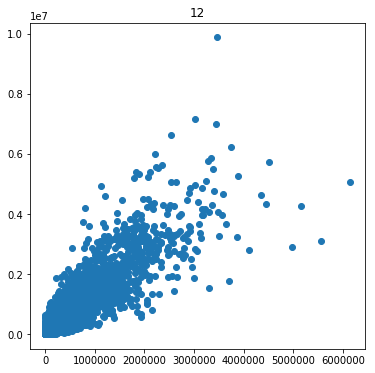

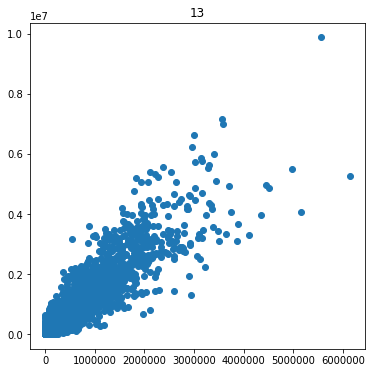

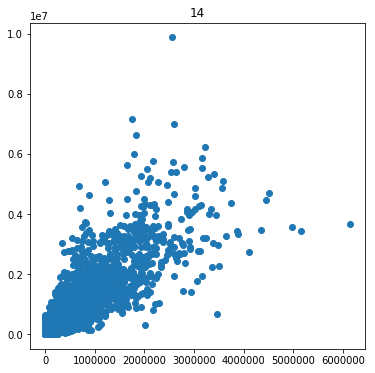

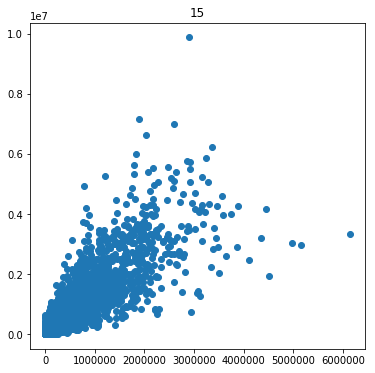

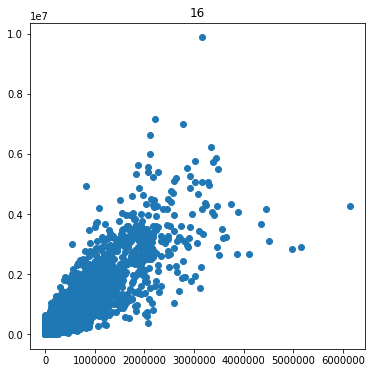

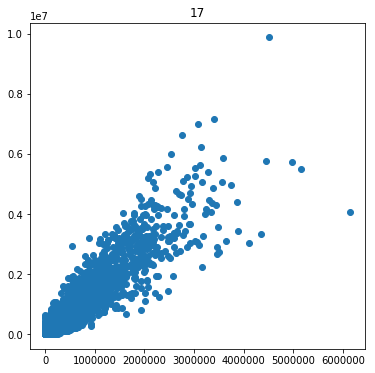

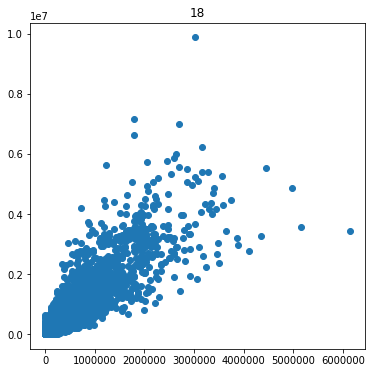

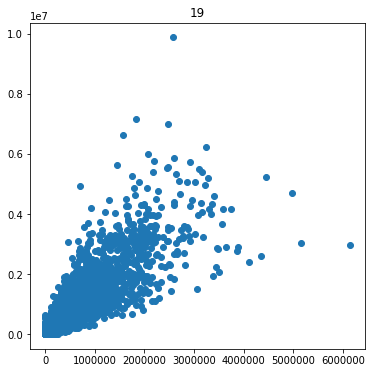

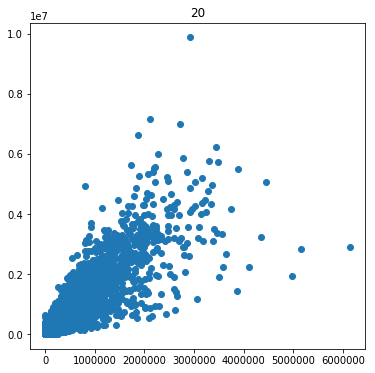

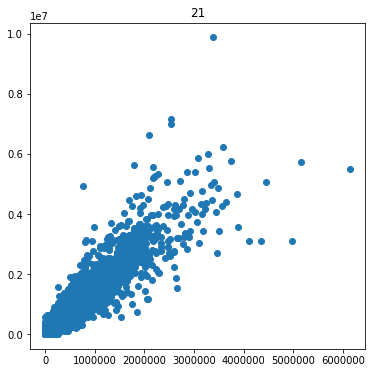

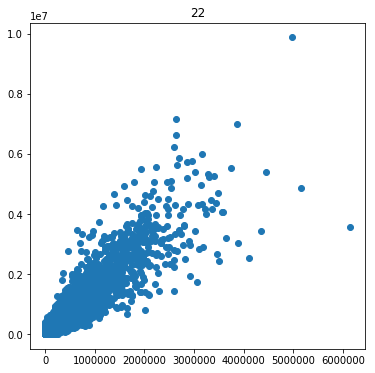

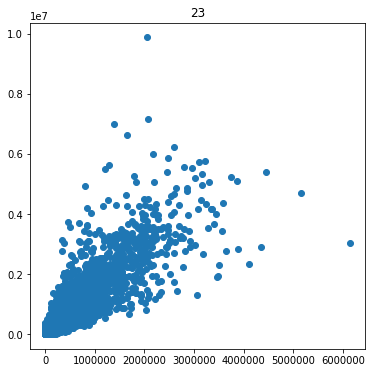

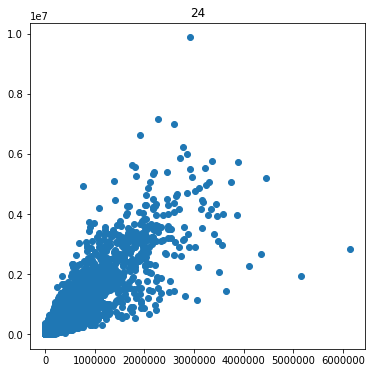

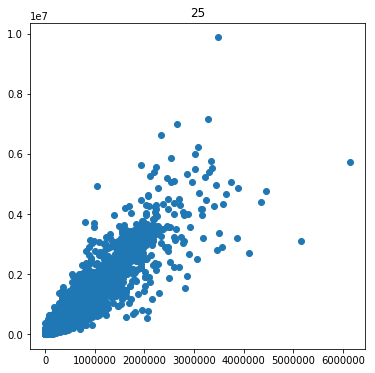

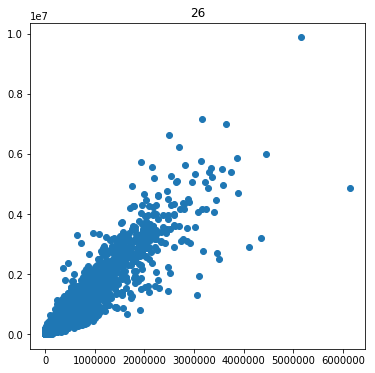

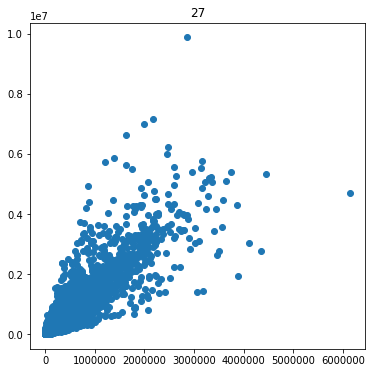

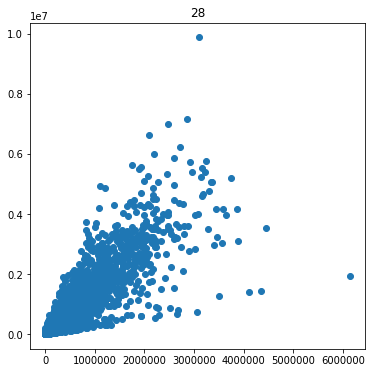

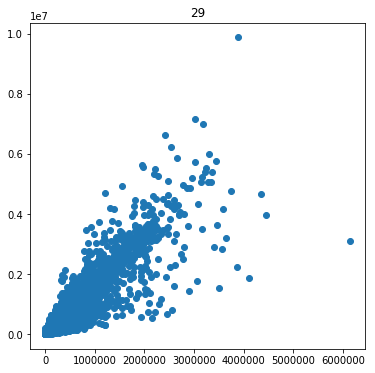

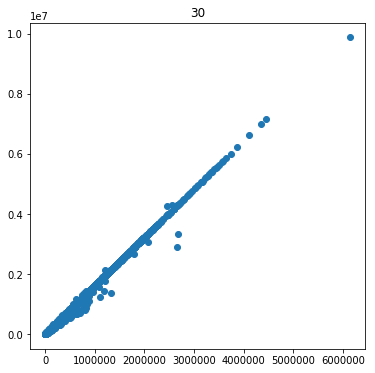

In [917]:
for i in range(1, 31):
    plt.figure(figsize=(6, 6))
    plt.title(str(i))
    plt.scatter(merged_table['f'+str(i)], merged_table['y'])
    plt.show()

Любопытная зависимость фичи номер 30 от y:

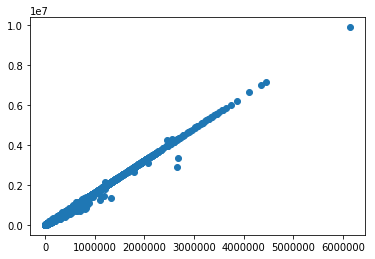

In [921]:
plt.scatter(merged_table['f30'], merged_table['y'])

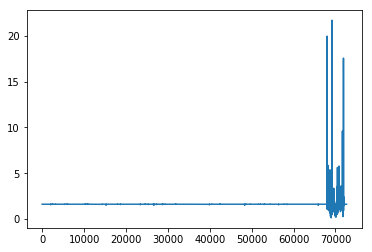

In [936]:
plt.plot(merged_table['y']/merged_table['f30'])

In [893]:
secret_test = pd.read_csv("train.tsv")[70000:]
secret_train = pd.read_csv("train.tsv")[:70000]

In [894]:
secret_test.rename_axis({"y": "answers"}, axis=1, inplace=True)

In [895]:
def give_prediction(test_to_predict, train_to_fit):
    
    test = deepcopy(test_to_predict)
    train = deepcopy(train_to_fit)
    correct_Y = deepcopy(train[['y', 'year', 'week', 'item_id']])
    transform(test)
    transform(train)
    test.drop(['shift', 'Num'], axis=1, inplace=True)
    train.drop(['shift', 'Num', 'y'], axis=1, inplace=True)
    train = train.drop_duplicates()
    
    merged_table = pd.merge(train, correct_Y, how='right', on=['year', 'week', 'item_id'])
    merged_table = merged_table.drop_duplicates()
    merged_table = merged_table.dropna()
    
    print(len(merged_table), len(test))
    
    cheat_codes_by_test = test[['year', 'week', 'item_id', 'f60']]
    cheat_codes_by_test.f60 = cheat_codes_by_test.f60.apply(lambda x: x * 1.609)
    cheat_codes_by_test.rename_axis({'f60': 'y'}, axis=1, inplace=True)
    cheat_codes_by_train = merged_table[['year', 'week', 'item_id', 'y']]
    cheat_codes = pd.concat([cheat_codes_by_train, cheat_codes_by_test])
    cheat_codes.drop_duplicates(inplace=True)
    
    return cheat_codes

In [896]:
def naive_predict(test_to_ans, train_to_fit, max_depth=18, alpha=0, lambd=1):
    train = deepcopy(train_to_fit)
    transform(train)
    train = train.iloc[:, :36]
    train.drop(['shift', 'Num'], axis=1, inplace=True)
    naive = XGBRegressor(max_depth=max_depth, reg_alpha=alpha, reg_lambda=lambd, n_estimators=100, nthread=2, seed=41)
    y = train['y']
    x = train.drop('y', axis=1)
    
    naive.fit(x, y)
    
    test = deepcopy(test_to_ans)
    transform(test)
    test = test.iloc[:, :35]
    test.drop(['shift', 'Num'], axis=1, inplace=True)
    
    return naive.predict(test)

In [897]:
def merge_results(predict_with_na, naive):
    predict = deepcopy(predict_with_na)
    naive_copy = deepcopy(naive)
    for i in range(len(predict)):
        if pd.isnull(predict[i]):
            predict[i] = naive_copy[i]
    return predict

In [898]:
cheat_codes = give_prediction(secret_test, secret_train)

(23108, 2457)


In [899]:
ans_table = pd.merge(secret_test, cheat_codes, how='left', on=['week', 'year', 'item_id'])

In [900]:
predict = ans_table['y']
y_real = ans_table['answers']

In [858]:
predict.isnull().sum()

684

In [902]:
naive_results = naive_predict(secret_test.drop(['answers'], axis=1), secret_train)

In [903]:
merged = merge_results(predict, naive_results)

IndexError: index 2457 is out of bounds for axis 0 with size 2457

In [ ]:
smape100(merged, y_real)

In [866]:
for d in range(15, 20):
    print d
    naive_results = naive_predict(secret_test.drop(['answers'], axis=1), secret_train, max_depth=d)
    merged = merge_results(predict, naive_results)
    print smape100(merged, y_real)

15
8.28127370343
16
7.90952971776
17
7.64557367177
18
7.65321061181
19
7.66915442731


In [867]:
naive_results = naive_predict(secret_test.drop(['answers'], axis=1), secret_train, max_depth=20)
merged = merge_results(predict, naive_results)
print smape100(merged, y_real)

7.83080997726


In [869]:
for a in np.arange(0, 1, 0.15):
    print(a)
    naive_results = naive_predict(secret_test.drop(['answers'], axis=1), secret_train, max_depth=17, alpha=a)
    merged = merge_results(predict, naive_results)
    print smape100(merged, y_real)

0.0
7.64557367177
0.15
7.71525569455
0.3
7.63309332623
0.45
7.6024585147
0.6
7.69697582093
0.75
7.67623340736
0.9
7.68307588615


In [874]:
for a in np.arange(0, 1, 0.15):
    b = 1.0 - a
    print(b)
    naive_results = naive_predict(secret_test.drop(['answers'], axis=1), secret_train, max_depth=17, lambd=b)
    merged = merge_results(predict, naive_results)
    print smape100(merged, y_real)

1.0
7.64557367177
0.85
7.73625121645
0.7
7.67925966156
0.55
7.5155113856
0.4
7.78985331425
0.25
7.92032926211
0.1
7.8558096969


In [875]:
naive_results = naive_predict(secret_test.drop(['answers'], axis=1), secret_train, max_depth=17, alpha=0.45, lambd=0.55)
merged = merge_results(predict, naive_results)
print smape100(merged, y_real)

7.68169723746


In [901]:
naive_results = naive_predict(secret_test.drop(['answers'], axis=1), secret_train, max_depth=17, alpha=0, lambd=0.55)
merged = merge_results(predict, naive_results)
print smape100(merged, y_real)

IndexError: index 2457 is out of bounds for axis 0 with size 2457

2.9674728291609509

In [877]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")

In [878]:
cheat_codes = give_prediction(test, train)

(24221, 2016)


In [879]:
ans_table = pd.merge(test, cheat_codes, how='left', on=['week', 'year', 'item_id'])

In [880]:
predict = ans_table['y']

In [883]:
naive_results = naive_predict(test, train, max_depth=17, alpha=0, lambd=0.55)

In [884]:
merged = merge_results(predict, naive_results)

In [885]:
sample_submission = pd.read_csv("sample_submission.tsv")

In [886]:
sample_submission['y'] = merged

In [887]:
sample_submission.to_csv("17_DEPTH_SOL.tsv", sep=',', index=False)

In [891]:
train

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,0,123438,2012,52,1,20442076,4915.0,38056.0,40185.0,45733.0,...,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0
1,1,58410,2012,52,1,20441997,2230.0,18817.0,20110.0,26368.0,...,22830.0,25230.0,27850.0,21390.0,27090.0,23170.0,29705.0,19140.0,22055.0,23200.0
2,2,163930,2012,52,1,20441990,5695.0,47480.0,47619.0,89708.0,...,14930.0,44290.0,46412.0,29320.0,21140.0,28406.0,65056.0,31886.0,48750.0,36520.0
3,3,53902,2012,52,1,20441989,1995.0,17146.0,20066.0,27070.0,...,15120.0,12480.0,19780.0,7990.0,8230.0,10650.0,21920.0,13040.0,9780.0,9630.0
4,4,105970,2012,52,1,20441988,6515.0,49262.0,50045.0,95167.0,...,18872.0,19328.0,37168.0,13570.0,19760.0,20208.0,34745.0,18442.0,24700.0,21793.0
5,5,21171,2012,52,1,20441953,445.0,3020.0,2395.0,4015.0,...,8796.0,7690.0,13448.0,3455.0,7205.0,8490.0,10790.0,7855.0,8150.0,7505.0
6,6,63128,2012,52,1,20441952,445.0,3930.0,4260.0,6836.0,...,11754.0,8064.0,15275.0,4991.0,9025.0,12236.0,19830.0,8465.0,10770.0,13145.0
7,7,44001,2012,52,1,20441951,1167.0,15220.0,12310.0,17270.0,...,21102.0,20376.0,25385.0,11685.0,21389.0,16685.0,22805.0,14495.0,16462.0,19383.0
8,8,53202,2012,52,1,20441790,1640.0,22010.0,17716.0,21941.0,...,18301.0,17758.0,26181.0,11090.0,17705.0,17225.0,23385.0,13711.0,17175.0,22406.0
9,9,36627,2012,52,1,20441789,1440.0,14601.0,12127.0,17498.0,...,13531.0,15015.0,18574.0,9146.0,14865.0,13051.0,17389.0,10739.0,13260.0,15570.0


In [890]:
cheat_codes

,year,week,item_id,y
0,2012,52,20442092,1175.000
1,2012,52,20442091,1175.000
2,2012,52,20442076,123438.000
3,2012,52,20441997,58410.000
4,2012,52,20441990,163930.000
5,2012,52,20441989,53902.000
6,2012,52,20441988,105970.000
7,2012,52,20441953,21171.000
8,2012,52,20441952,63128.000
9,2012,52,20441951,44001.000
